In [38]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [47]:
with open('data/reviews_post_feature_eng.pkl', 'rb') as f:
    reviews = pickle.load(f)

#### Feature Importance: All Features

In [48]:
def select_fetures(dataset, features):
    return dataset[features]

In [49]:
features = ['HelpfullnessRank', 'Score', 'Time', 
       'WordsCount',  'Total_Reviews_by_Reviewer',
       'ProductFrequency', 'WordCount',
       'WordCountSummary', 'StopWords', 'UpperCount', 'UpperCountSummary',
       'LowerCount', 'LowerCountSummary', 'DotCount', 'DotCountSummary',
       'Exclamation', 'ExclamationSummary', 'Question', 'QuestionSummary',
       'CountPunctuation', 'CountPunctuationSummary', 'CountDigits',
       'CountDigitsSummary', 'Lexical', 'LexicalSummary', 'UpperLowerR',
       'UpperLowerSumR', 'DotCapitalR', 'DotCapitalSumR', 'CapitalsRatio',
       'neg', 'neu', 'pos', 'compound', 'ProductFreqlog',
       'ReviewsbyReviewerlog', 'WordCountlog', 'Year', 'Month',
       'Day']

reviews_features = select_fetures(reviews, features)

In [50]:
label = 'HelpfullnessRank'
X = reviews_features.drop(label, axis=1)
y = reviews_features

# Split to train, test and validation datasets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

X_train.shape, X_test.shape, X_val.shape

((53481, 39), (17827, 39), (17827, 39))

In [17]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train[label])
rnd_val_pred = clf.predict(X_val)
rnd_train_pred = clf.predict(X_train)
print("Validation accuracy score: ", accuracy_score(rnd_val_pred, y_val[label]))
print("Train accuracy score: ", accuracy_score(rnd_train_pred, y_train[label]))

Validation accuracy score:  0.6251192012116452
Train accuracy score:  0.9919597614105944


In [24]:
feature_importance_full = list(zip(X_train.columns, clf.feature_importances_))

with open('data/feature_importance_full.pkl', 'wb') as f:
    pickle.dump(feature_importance_full, f)

#### Feature Selection

In [35]:
from sklearn.feature_selection import RFE
from IPython.display import clear_output


def eliminate_features(X, y, n_features):
    """
    Eliminate features from data set
    
    Args:
        X(pd.DataFram): dataset's features
        y(pd.Series): dataset's labels
        n_features(int): the required number of features
    
    Returns:
        np.array: features mask
    """
    estimator = RandomForestClassifier()
    selector = RFE(estimator, n_features)
    selector = selector.fit(X, y)
    feature_mask = selector.support_
    
    return feature_mask

def rnd_forest(X, y, features_mask):
    """
    Split the dataset into test and train using the feature elimination mask and returns the mse score
    for linear regression
    
    Args:
       X(pd.DataFram): dataset's features
       y(pd.Series): dataset's labels
       features_mask(np.array): the required number of features
    
    
    Returns:
        (float): mse accuracy score for linear regression model
    
    """
    X = X.loc[:,features_mask]
    
    # Split to train, test and validation datasets:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
    
    
    # Use Random Forest:
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    
    # Predict 
    y_pred = clf.predict(X_val)
    # Calculate accuracy_score and return:
    return accuracy_score(y_val, y_pred)


def rnd_vs_features(X, y, original_feature_no ):
    """
    Plot the mse score vs. the number of features used for linear regression
    
    Args:
        X(pd.DataFram): dataset's features
        y(pd.Series): dataset's labels 
        original_feature_no(int): the original number of features
    """
    accuracy_scores = []
    feature_masks = []
    feature_no = np.arange(1, original_feature_no + 1)
    
    for n in feature_no:
        print(n)
        clear_output(wait=True)
        features_mask = eliminate_features(X, y, n)
        accuracy_scores.append(rnd_forest(X, y, features_mask))
        feature_masks.append(features_mask)
    return accuracy_scores, feature_masks



In [36]:
original_feature_no = X_train.shape[1]
accuracy_scores, feature_masks = rnd_vs_features(X, y[label], original_feature_no )

39


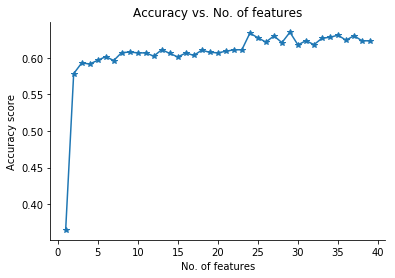

In [39]:
feature_no = np.arange(1, original_feature_no + 1)
len(accuracy_scores), len(feature_no)

plt.plot(feature_no, accuracy_scores,'-*')
plt.gca().set_title('Accuracy vs. No. of features')
plt.gca().set_xlabel('No. of features')
plt.gca().set_ylabel('Accuracy score')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#### Feature Importance: Selected Features

In [64]:
# The number of feature which result with the maximum validation accuracy:
ind_max = accuracy_scores.index(max(accuracy_scores))
selected_feature_max = feature_masks[ind_max] # the relevant feature mask

# X_ = X.loc[:,selected_feature_max]
X_.columns

Index(['Score', 'Time', 'WordsCount', 'Total_Reviews_by_Reviewer',
       'ProductFrequency', 'WordCount', 'WordCountSummary', 'StopWords',
       'UpperCount', 'LowerCount', 'LowerCountSummary', 'DotCount',
       'CountPunctuation', 'CountDigits', 'Lexical', 'UpperLowerR',
       'UpperLowerSumR', 'DotCapitalR', 'DotCapitalSumR', 'CapitalsRatio',
       'neg', 'neu', 'pos', 'compound', 'ProductFreqlog',
       'ReviewsbyReviewerlog', 'WordCountlog', 'Month', 'Day'],
      dtype='object')

In [61]:
ind_max

28

In [60]:
with open('data/feature_selection_accuracy.pkl', 'wb') as f:
    pickle.dump(accuracy_scores, f)
    
with open('data/feature_selection_masks.pkl', 'wb') as f:
    pickle.dump(feature_masks, f)

In [53]:
features = ['HelpfullnessRank', 'Score', 'Time', 'WordsCount', 'Total_Reviews_by_Reviewer',
        'ProductFrequency', 'WordCount', 'WordCountSummary', 'StopWords',
        'UpperCount', 'LowerCount', 'LowerCountSummary', 'DotCount',
        'CountPunctuation', 'CountDigits', 'Lexical', 'UpperLowerR',
        'UpperLowerSumR', 'DotCapitalR', 'DotCapitalSumR', 'CapitalsRatio',
        'neg', 'neu', 'pos', 'compound', 'ProductFreqlog',
        'ReviewsbyReviewerlog', 'WordCountlog', 'Month', 'Day']

reviews_features = select_fetures(reviews, features)

In [54]:
label = 'HelpfullnessRank'
X = reviews_features.drop(label, axis=1)
y = reviews_features[label]

# Split to train, test and validation datasets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

X_train.shape, X_test.shape, X_val.shape

((53481, 29), (17827, 29), (17827, 29))

In [57]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
rnd_val_pred = clf.predict(X_val)
rnd_train_pred = clf.predict(X_train)
print("Validation accuracy score: ", accuracy_score(rnd_val_pred, y_val))
print("Train accuracy score: ", accuracy_score(rnd_train_pred, y_train))

Validation accuracy score:  0.6154148202165255
Train accuracy score:  0.9926889923524242


In [58]:
feature_importance_partial = list(zip(X_train.columns, clf.feature_importances_))

with open('data/feature_importance_partial.pkl', 'wb') as f:
    pickle.dump(feature_importance_partial, f)